In [30]:
import sys
import yaml
import pyart
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../scripts')
import core
from calculate_distances import aname

In [31]:
colors = {
    'C': 'navy',
    'G': 'seagreen',
    'N': 'orangered',
    'GB':'crimson',
    'CB':'darkorchid',
    'GM':'mediumturquoise',
    'CM':'darkcyan',
}
cmap = f'pyart_balance'

In [32]:
win=100
nbasis=15
exp = 'nat8a'
dataset = 'alpha'
stim_info = pd.read_csv(f"../inputs/stimuli/{exp}-info.csv")
spectrograms = pd.read_csv(f"../build/{exp}/spectrograms.csv", index_col=[0,1])
motifs = stim_info.motif.unique()
gaps = stim_info[stim_info.type=='gap'].groupby(['motif','gap']).first()[['gap_start', 'gap_stop']]
with open(f"../inputs/nat8-familiarity-coding.yml") as famfile:
    familiarity = yaml.safe_load(famfile)
models = joblib.load(
    f"../output/{exp}/{dataset}_PLS_models.pkl")
motifs

array(['B189', 'B2', 'B30', 'B72', 'O129', 'R180', 'R253', 'R56'],
      dtype=object)

In [33]:
sns.set_style('white')
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [47]:
m = motifs[4]
g = 2
ga, gb = gaps.loc[m, g].astype(int)

coefs = models[m].coef_
responses = pd.read_hdf(f"../build/{exp}/responses_{dataset}.h5", key='Induction')
sort_by_weight = pd.Series(
    np.abs(coefs).reshape(coefs.shape[0], int(coefs.shape[1]/nbasis), nbasis).sum(axis=2).sum(axis=0),
    index = responses.columns
).sort_values(ascending=False)
resps = responses[sort_by_weight.index]

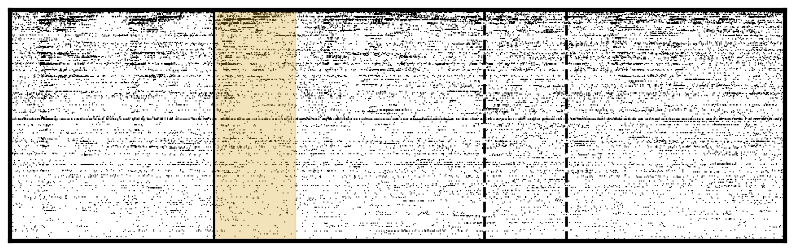

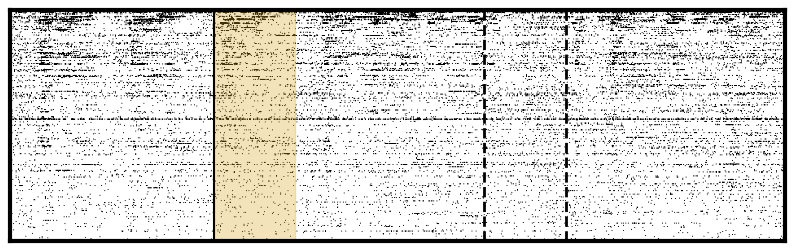

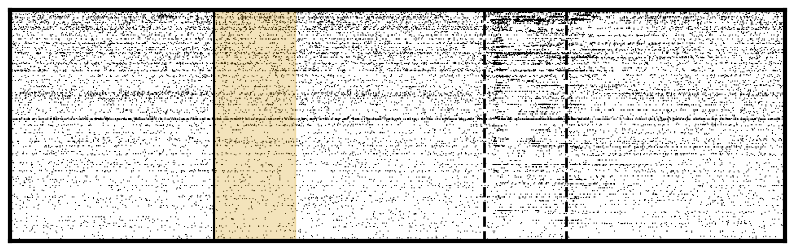

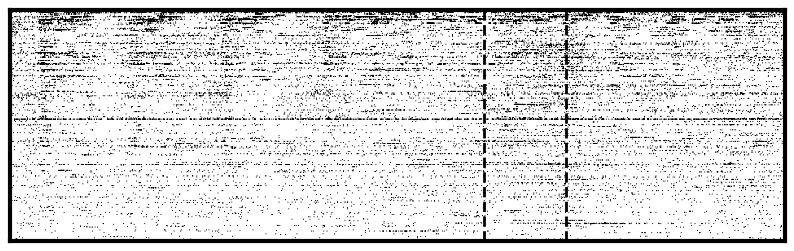

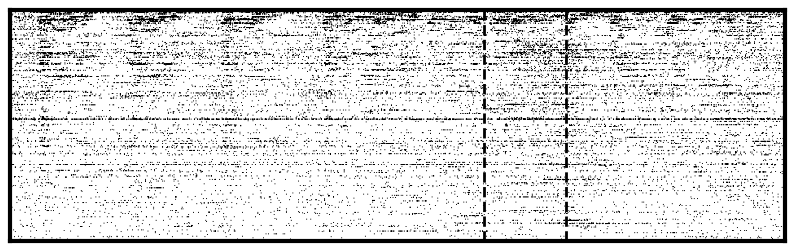

In [48]:
for c in ['C', 'G', 'N', 'GB', 'CB']:
    ax = plt.figure(figsize=(10,3)).add_subplot()
    stim = aname(m, c, g)
    spec=spectrograms.loc[stim]
    tmax = spec.index.get_level_values('time').max()
    ax.imshow(
        resps.loc[stim].loc[0:tmax].T, aspect='auto', cmap='binary',
        vmin=0, vmax=0.05
    )
    ax.axvline(ga, color='black', ls='--', lw=2)
    ax.axvline(gb, color='black', ls='--', lw=2)    
    ax.set_xticks([0,300, 600, 900], [])
    # ax.set_xticks([0,500,1000], [])

    ax.set_ylim(407,0)
    ax.set_yticks([0,407], [])
    # ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.setp(ax.spines.values(), lw=3, color='black')
    if c in ['C','G','N']:
        ax.fill_between([250, 350],
                        y1=0, y2=407,
                        color='goldenrod', alpha=0.3)
        ax.axvline(250, color='black')

In [36]:
model = models[m]
conditions = ['C','G','CB','GB','N']

xscores = {}
yscores = {}

responses = pd.read_hdf(f"../build/{exp}/{dataset}_delemb_win{win}_basis{nbasis}.h5", key="Induction")
cstim = spectrograms.loc[aname(m, 'C', g)]

for c in conditions:
    stim = aname(m, c, g)
    X, Y = model.transform(
        X = responses.loc[stim].loc[cstim.index],
        Y = spectrograms.loc[stim].loc[cstim.index] 
    )
    xscores[c] = X
    yscores[c] = Y

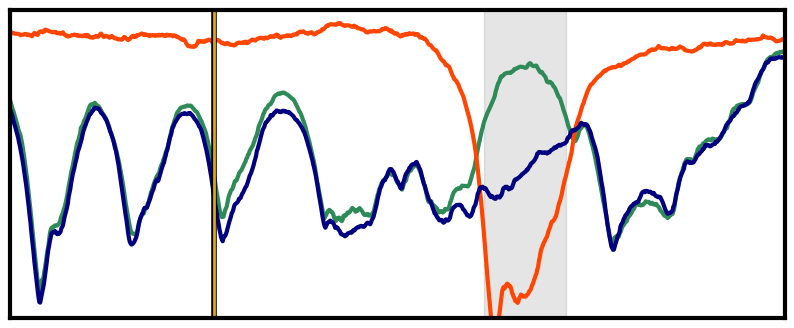

In [49]:
ax = plt.figure(figsize=(10,4)).add_subplot()
ax.fill_between([ga, gb], y1=1, y2=-3.,
                color='black', alpha=0.1)
for c in ['G', 'N', 'C']:
    ls = '-'
    stim = aname(m, c, g)
    ax.plot(xscores[c][:, 0], color=colors[c], lw=3, ls=ls)
ax.set_xticks([0,300, 600, 900], [])
# ax.set_xticks([0, 500, 1000], [])

ax.set_yticks([-2,-1,0], [])
ax.set_ylim([-2.6,0.5])
ax.set_xlim(0, tmax)
ax.axvline(250, color='black', lw=4)
ax.axvline(250, color='goldenrod', lw=2)
plt.setp(ax.spines.values(), lw=3, color='black');

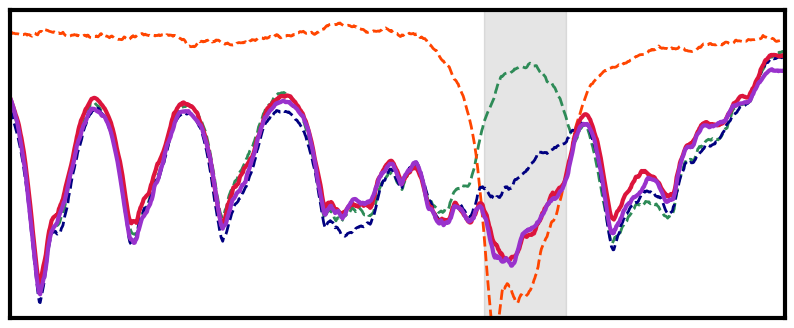

In [50]:
ax = plt.figure(figsize=(10,4)).add_subplot()
ax.fill_between([ga, gb], y1=1, y2=-3.,
                color='black', alpha=0.1)
for c in ['G', 'N', 'C']:
    ls = '-'
    stim = aname(m, c, g)
    ax.plot(xscores[c][:, 0], color=colors[c], lw=2, ls='--')

for c in ['GB', 'CB']:
    ls = '-'
    stim = aname(m, c, g)
    ax.plot(xscores[c][:, 0], color=colors[c], lw=3, ls='-')
ax.set_xticks([0, 500, 1000], [])

ax.set_yticks([-2,-1,0], [])
ax.set_ylim([-2.6,0.5])
ax.set_xlim(0, tmax)
plt.setp(ax.spines.values(), lw=3, color='black');

[None, None, None, None, None, None, None, None]

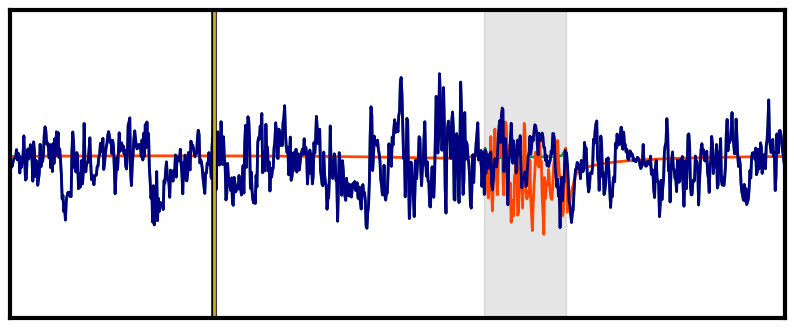

In [51]:
ax = plt.figure(figsize=(10,4)).add_subplot()
ax.fill_between([ga, gb], y1=-350, y2=350,
                color='black', alpha=0.1)

for c in ['G', 'N', 'C']:
    stim = aname(m, c, g)
    ax.plot(yscores[c][:, 0], color=colors[c], lw=2)

ax.set_xticks([0,300, 600, 900], [])
ax.set_xlim(0, tmax)
ax.set_yticks([-300,0,300], [])
ax.set_ylim([-350,350])
ax.axvline(250, color='black', lw=4)
ax.axvline(250, color='goldenrod', lw=2)
plt.setp(ax.spines.values(), lw=3, color='black')

[None, None, None, None, None, None, None, None]

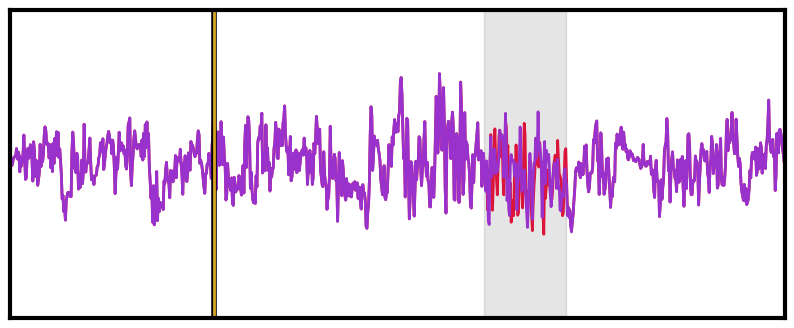

In [52]:
ax = plt.figure(figsize=(10,4)).add_subplot()
ax.fill_between([ga, gb], y1=-350, y2=350,
                color='black', alpha=0.1)

for c in ['GB', 'CB']:
    stim = aname(m, c, g)
    ax.plot(yscores[c][:, 0], color=colors[c], lw=2)

ax.set_xticks([0,300, 600, 900], [])
ax.set_xlim(0, tmax)
ax.set_yticks([-300,0,300], [])
ax.set_ylim([-350,350])
ax.axvline(250, color='black', lw=4)
ax.axvline(250, color='goldenrod', lw=2)
plt.setp(ax.spines.values(), lw=3, color='black')

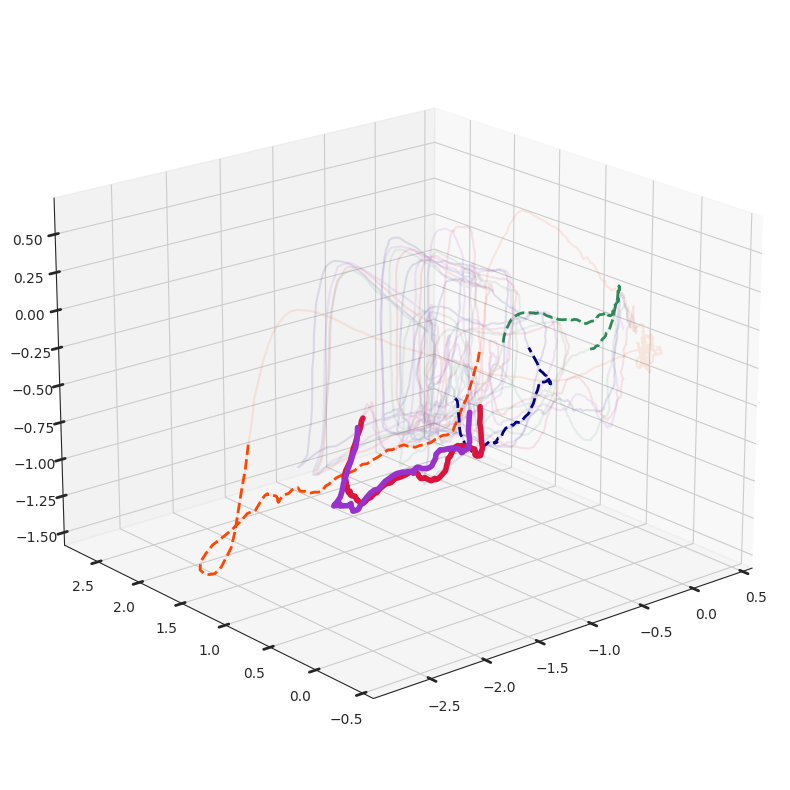

In [59]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
plt.setp(ax.spines.values(), lw=3, color='black')

for c in ['G', 'N', 'C', 'GB', 'CB']:

    ax.plot(
        xscores[c][:, 0],
        xscores[c][:, 1],
        xscores[c][:, 2],
        color=colors[c],
        alpha=0.10
    )
    lw = 4 if c in ['GB', 'CB'] else 2
    ls = '-' if c in ['GB', 'CB'] else '--'
    ax.plot(
        xscores[c][ga:gb, 0],
        xscores[c][ga:gb, 1],
        xscores[c][ga:gb, 2],
        color=colors[c],
        alpha=1,
        lw=lw,
        ls=ls,
    )

    
ax.view_init(elev=20, azim=230, roll=0)

# # # ax.set_xlabel('Dim 0')
# ax.set_xlim(-5.5,-2.5)
# ax.set_xticks([-5,-4,-3,-2], [])

# # # ax.set_ylabel('Dim 1')
# ax.set_ylim(-2.5,1.5)
# ax.set_yticks([-2,-1,0,1], [])

# # # ax.set_zlabel('Dim 2')
# ax.set_zlim(-2.5,-0.5)
# ax.set_zticks([-2,-1], [])


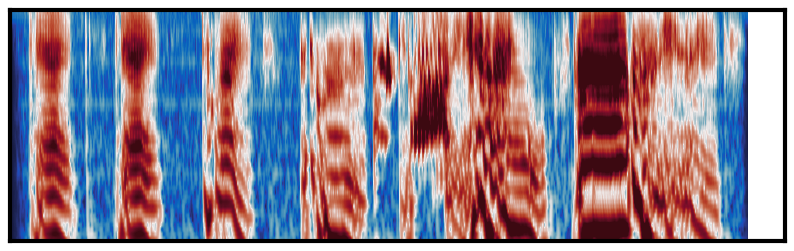

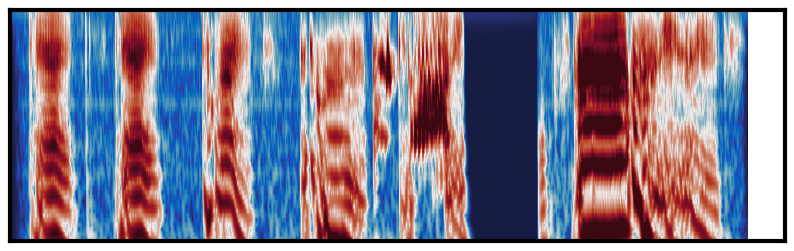

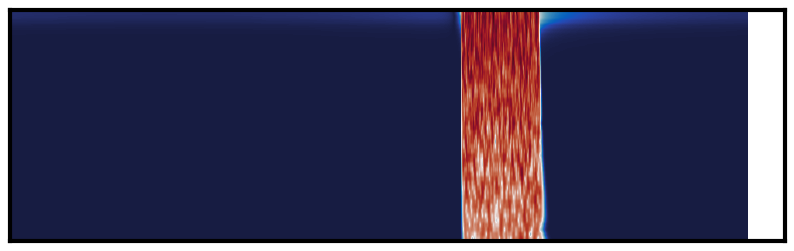

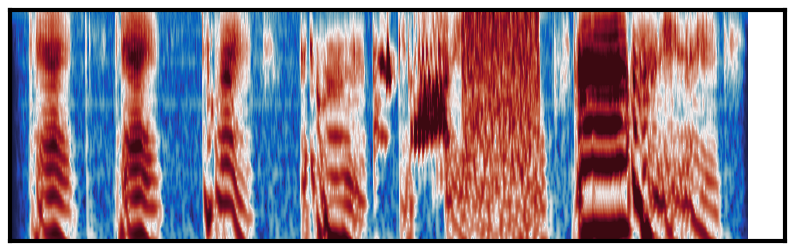

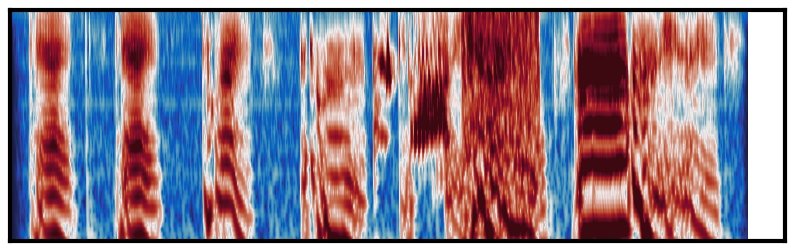

In [61]:
m = motifs[4]
g = 2
ga, gb = gaps.loc[m, g].astype(int)

for c in ['C','G','N','GB','CB']:
    ax = plt.figure(figsize=(10,3)).add_subplot()
    stim = aname(m, c, g)
    spec=spectrograms.loc[stim]
    tmax = spec.index.get_level_values('time').max()
    ax.imshow(spec.T.iloc[::-1], aspect='auto', vmax=2.7, vmin=0, cmap=cmap)
    ax.set_xticks([0,500, 1000], [])
    ax.set_yticks([0,49], [])
    plt.setp(ax.spines.values(), lw=3, color='black')